# EDMD Ablation study based on num trajectories


### config setup

In [26]:
# === Config ===
from pathlib import Path

# Choose one: 'build' (fit+save models), 'eval' (load+evaluate), or 'both'
MODE = 'both'   # 'build' | 'eval' | 'both'

ROOT = Path("../../datasets/go1/flat_terrain")
TEST_FILE = ROOT / "experiment2.h5"
TRAIN_FILES = [ROOT / f"experiment{i}.h5" for i in range(3, 7)]

TRAJ_COUNTS = [10, 100, 200, 300, 400, 500]   # models to build when MODE includes 'build'
P_MAX  = 5
L2_REG = 1e-6
H      = 100
SEED   = 4587
DT     = 0.002  # s
N_WINDOWS = 100  # how many random test windows per model in MODE='eval'
MODEL_DIR = Path("./saved_models_koopman")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

assert MODE in ('build','eval','both')
print(f"[config] MODE={MODE} | save dir={MODEL_DIR.resolve()}")

[config] MODE=both | save dir=/home/sriramk/quad_koopman_mpc/simulation/edmd/saved_models_koopman


### imports and helpers

In [14]:
# === Imports & helpers ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, h5py, json, time
from typing import List, Tuple, Dict, Any
from pathlib import Path

from h5_reader import H5Reader
from data_loader import QuadrupedEDMDDataset

# EDMD (covariance form) + geometric lift wrappers from the updated runner
from edmd_runner import edmd_with_inputs, lift_1d, lift_row
from eval_nstep import eval_nstep_window

rng = np.random.default_rng(SEED)
plt.rcParams["figure.dpi"] = 150

def build_ds(h5_path: Path, downsample=1, pos_zero_start=True, normalize=None):
    reader = H5Reader(file_path=str(h5_path), lazy=True)
    return QuadrupedEDMDDataset(
        dataset=reader,
        downsample=downsample,
        pos_zero_start=pos_zero_start,
        normalize=normalize
    ).build()

def episode_transition_slices(h5_path: Path):
    """
    Return (start, length) for each episode's transitions in the flattened arrays.
    Assumes fixed-length episodes in HDF5: recordings/base_pos has shape (E, T, 3).
    Each episode contributes (T-1) one-step transitions.
    """
    h5_path = Path(h5_path)
    with h5py.File(h5_path, "r") as f:
        E, T, _ = f["recordings"]["base_pos"].shape
    length = max(T - 1, 0)
    starts = np.arange(E, dtype=int) * length
    return [(int(s), int(length)) for s in starts]

def default_labels(nx: int):
    return ["x","y","z","roll","pitch","yaw","vx","vy","vz","wx","wy","wz"] if nx == 12 else [f"x{i}" for i in range(nx)]

def wrap_to_pi(a: np.ndarray) -> np.ndarray:
    return (a + np.pi) % (2*np.pi) - np.pi

def compute_rmse(X_true: np.ndarray, X_pred: np.ndarray):
    err = X_pred - X_true
    if X_true.shape[1] == 12:
        err[:, 3:6] = wrap_to_pi(err[:, 3:6])
    rmse_per_state = np.sqrt(np.mean(err**2, axis=0))
    overall = float(np.sqrt(np.mean(rmse_per_state**2)))
    return rmse_per_state, overall

# Lift wrappers for EDMD fit/eval (per-sample 1-D φ expected by our pipeline)
lift_fn_train = lambda x, pmax=P_MAX: lift_1d(x, pmax)
lift_fn_eval  = lift_fn_train


### load train/test dataset and parse trajectories

In [15]:
# === Build TEST entries (always) ===
ds_test = build_ds(TEST_FILE, downsample=1, pos_zero_start=True, normalize=None)
nx = ds_test.X0.shape[1]
nu = ds_test.U0.shape[1] if (ds_test.U0.ndim == 2) else 0
labels = getattr(ds_test, "labels", None)
if labels is None or len(labels) != nx:
    labels = default_labels(nx)

test_entries = []
sl_test = episode_transition_slices(TEST_FILE)
N_test = ds_test.X0.shape[0]
for s, l in sl_test:
    if l <= 0 or s >= N_test: continue
    test_entries.append({"ds": ds_test, "start": s, "length": min(l, N_test - s)})
print(f"[info] TEST trajectories: {len(test_entries)} | nx={nx}, nu={nu}")

# === Build TRAIN pool only if needed ===
train_pool = []
if MODE in ('build','both'):
    for fp in TRAIN_FILES:
        if not fp.exists():
            print(f"[skip] missing {fp.name}"); continue
        ds = build_ds(fp, downsample=1, pos_zero_start=True, normalize=None)
        sl = episode_transition_slices(fp)
        N = ds.X0.shape[0]
        for s, l in sl:
            if l <= 0 or s >= N: continue
            train_pool.append({"ds": ds, "file": fp.name, "start": s, "length": min(l, N - s)})
    print(f"[info] TRAIN trajectories: {len(train_pool)}")


[info] TEST trajectories: 100 | nx=12, nu=12
[info] TRAIN trajectories: 400


### fit EDMD models and save

[saved] koopman_N10_seed4587.npz | ρ(A)=1.0004 | rank(C)=63/69
[saved] koopman_N100_seed4587.npz | ρ(A)=1.0003 | rank(C)=63/69
[saved] koopman_N200_seed4587.npz | ρ(A)=1.0004 | rank(C)=63/69
[saved] koopman_N300_seed4587.npz | ρ(A)=1.0004 | rank(C)=63/69
[saved] koopman_N400_seed4587.npz | ρ(A)=1.0004 | rank(C)=63/69
[saved] koopman_N400_seed4587.npz | ρ(A)=1.0004 | rank(C)=63/69

=== Model metrics (per saved model) ===


,file,N_traj,nphi,nu,max|eig(A)| (ρ),min|eig(A)|,ctrb_rank,ctrb_full?
0,koopman_N10_seed4587.npz,10,69,12,1.000400,0.0,63,False
1,koopman_N100_seed4587.npz,100,69,12,1.000324,0.0,63,False
2,koopman_N200_seed4587.npz,200,69,12,1.000384,0.0,63,False
3,koopman_N300_seed4587.npz,300,69,12,1.000412,0.0,63,False
4,koopman_N400_seed4587.npz,400,69,12,1.000404,0.0,63,False
5,koopman_N400_seed4587.npz,400,69,12,1.000404,0.0,63,False


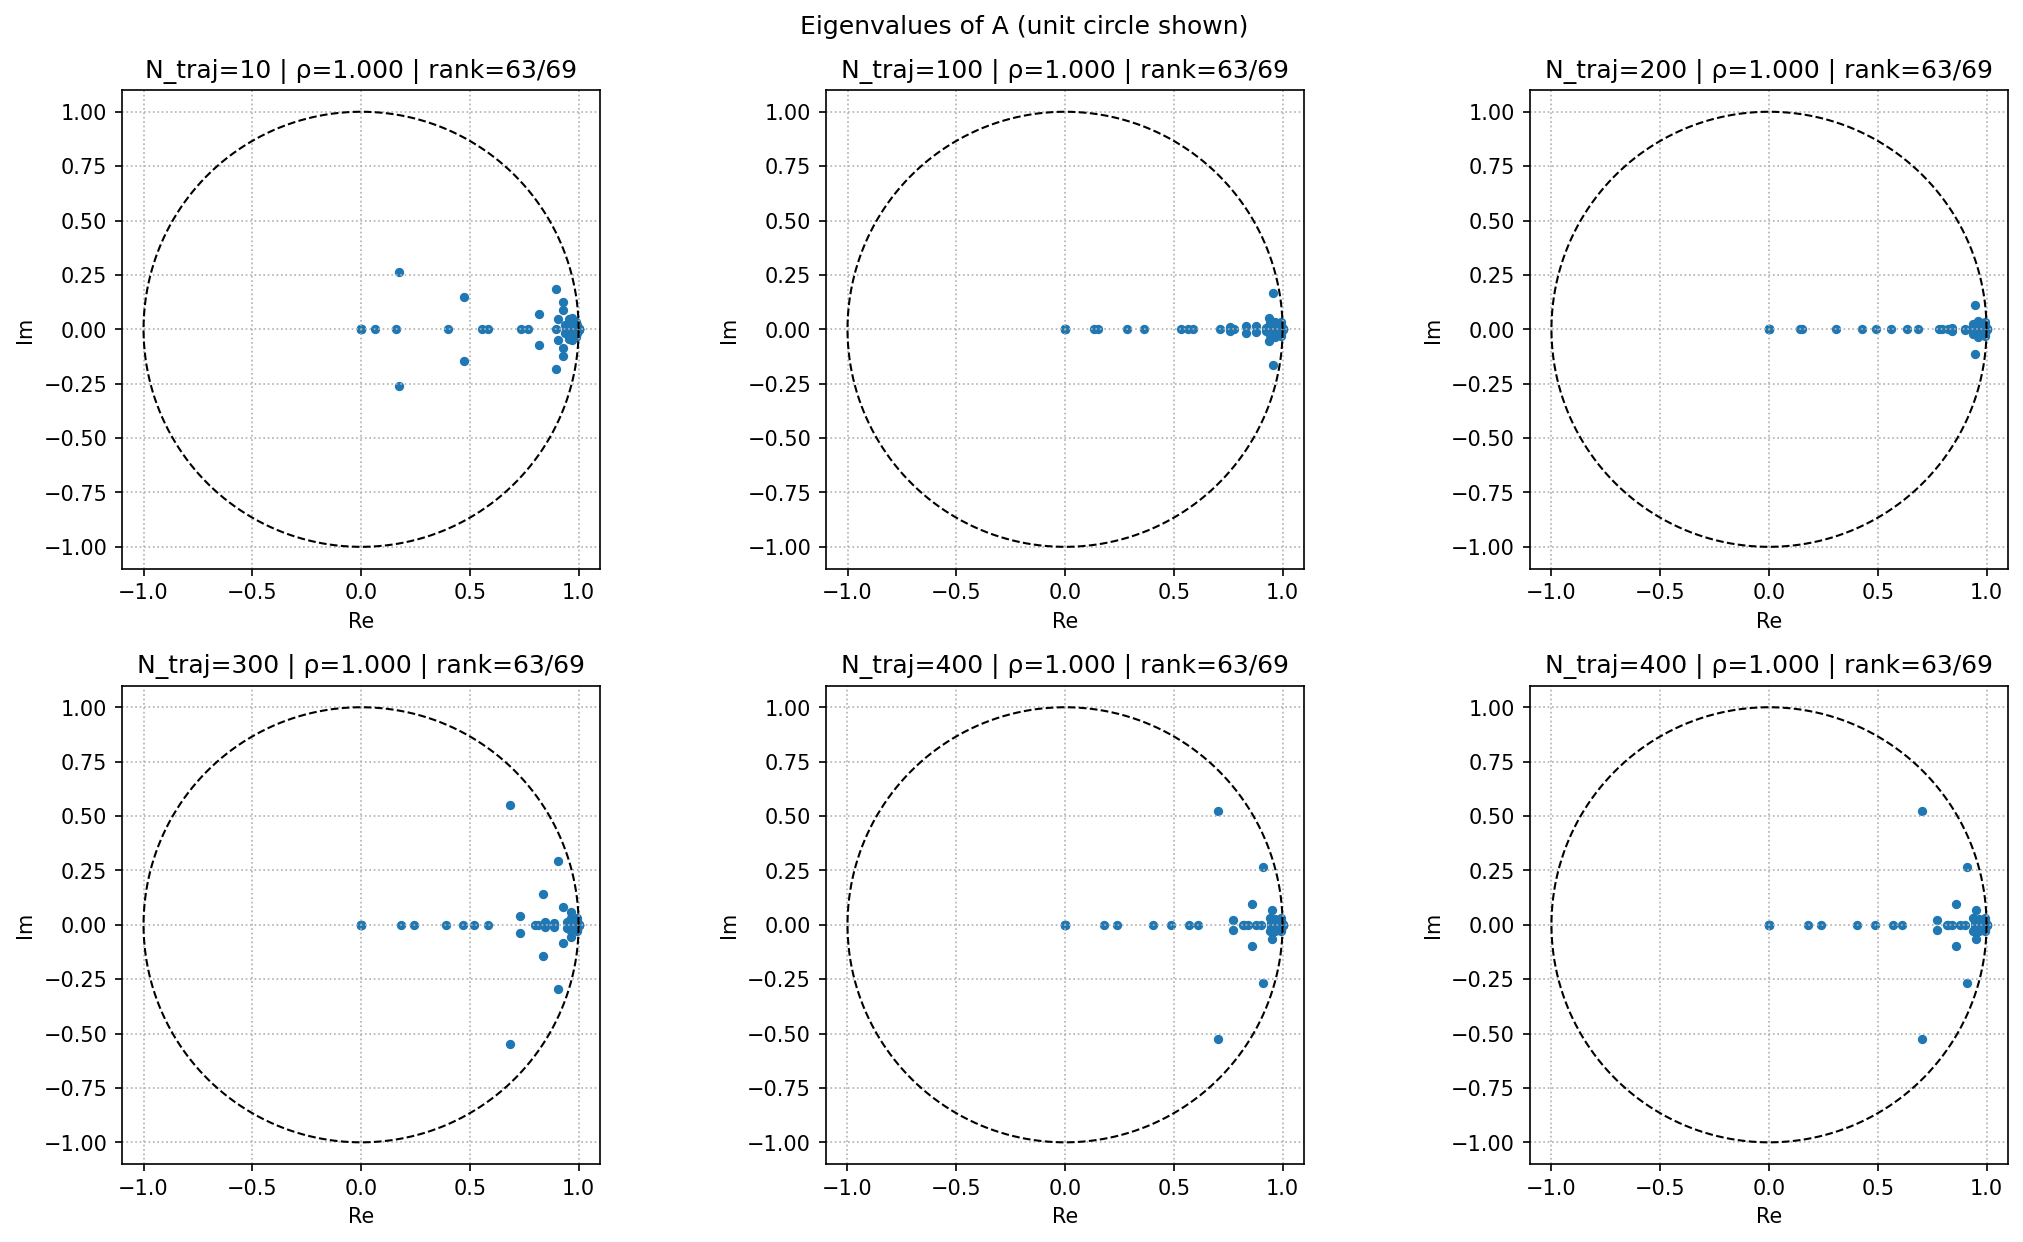

In [16]:
# === BUILD & SAVE models (+eigs & controllability) ===
if MODE in ('build', 'both'):
    assert len(train_pool) > 0, "No training trajectories."

    def save_model(path: Path, A, B, meta: dict):
        np.savez_compressed(path, A=A, B=B, meta=json.dumps(meta))

    built_rows = []
    eigen_records = []

    for N_traj in TRAJ_COUNTS:
        N_use = min(N_traj, len(train_pool))
        idxs = rng.choice(len(train_pool), size=N_use, replace=False)
        sel = [train_pool[i] for i in idxs]

        # ---- concatenate transitions from selected episodes ----
        X0 = np.vstack([e["ds"].X0[e["start"]:e["start"]+e["length"]] for e in sel])
        X1 = np.vstack([e["ds"].X1[e["start"]:e["start"]+e["length"]] for e in sel])
        U0 = np.vstack([
            e["ds"].U0[e["start"]:e["start"]+e["length"]]
            if (e["ds"].U0.ndim == 2 and e["ds"].U0.shape[1] > 0)
            else np.zeros((e["length"], 0), float)
            for e in sel
        ])

        # ---- EDMD (covariance form) with geometric basis (per-sample 1-D φ) ----
        A, B = edmd_with_inputs(
            X0, X1, U0,
            lift_fn=lambda x: lift_1d(x, P_MAX),
            l2_reg=L2_REG
        )

        # ---- eigs & controllability in lifted space ----
        eigA   = np.linalg.eigvals(A)
        eig_abs = np.abs(eigA)
        rhoA   = float(eig_abs.max())
        nphi   = A.shape[0]
        nu_l   = B.shape[1] if (B.ndim == 2) else 0

        if nu_l > 0:
            blocks, AB = [], B.copy()
            for _ in range(nphi):
                blocks.append(AB)
                AB = A @ AB
            Ctrb = np.hstack(blocks)           # (nphi, nphi*nu_l)
            rank_ctrb = int(np.linalg.matrix_rank(Ctrb))
        else:
            rank_ctrb = 0

        # ---- metadata & save ----
        meta = dict(
            N_traj=int(N_use), seed=int(SEED),
            p_max=int(P_MAX), l2_reg=float(L2_REG),
            nx=int(nx), nu=int(nu), nphi=int(nphi),
            dt=float(DT), labels=labels,
            rhoA=float(rhoA), ctrb_rank=int(rank_ctrb),
            traj_indices=[int(i) for i in idxs],
            timestamp=time.time(),
            notes="Geometric basis Φ=[pos, v, vec(R), vec(ω̂), vec(R ω̂^p)]; covariance EDMD; radians."
        )
        out = MODEL_DIR / f"koopman_N{N_use}_seed{SEED}.npz"
        save_model(out, A, B, meta)

        built_rows.append({
            "file": out.name,
            "N_traj": int(N_use),
            "nphi": int(nphi),
            "nu": int(nu_l),
            "max|eig(A)| (ρ)": rhoA,
            "min|eig(A)|": float(eig_abs.min()),
            "ctrb_rank": rank_ctrb,
            "ctrb_full?": (rank_ctrb == nphi),
        })
        eigen_records.append({
            "N_traj": int(N_use),
            "eigA": eigA,
            "rho": rhoA,
            "rank_ctrb": rank_ctrb,
            "nphi": nphi
        })
        print(f"[saved] {out.name} | ρ(A)={rhoA:.4f} | rank(C)={rank_ctrb}/{nphi}")

    # ---- summary table ----
    df_models = pd.DataFrame(built_rows).sort_values("N_traj")
    print("\n=== Model metrics (per saved model) ===")
    display(df_models)

    # ---- eigen-plots grid ----
    nplots = len(eigen_records)
    if nplots > 0:
        cols = 2 if nplots <= 4 else 3
        rows_grid = int(np.ceil(nplots / cols))
        fig, axes = plt.subplots(rows_grid, cols, figsize=(4.8*cols, 4.2*rows_grid))
        axes = np.array(axes).reshape(rows_grid, cols)

        th = np.linspace(0, 2*np.pi, 400)
        ucx, ucy = np.cos(th), np.sin(th)
        for k, rec in enumerate(sorted(eigen_records, key=lambda r: r["N_traj"])):
            r, c = divmod(k, cols)
            ax = axes[r, c]
            ax.plot(ucx, ucy, 'k--', linewidth=1.0)           # unit circle
            lam = rec["eigA"]
            ax.scatter(lam.real, lam.imag, s=12)
            ax.set_aspect('equal', 'box')
            ax.grid(True, linestyle=':')
            ax.set_xlabel("Re")
            ax.set_ylabel("Im")
            ax.set_title(f"N_traj={rec['N_traj']} | ρ={rec['rho']:.3f} | rank={rec['rank_ctrb']}/{rec['nphi']}")
        # blank unused subplots
        for k in range(nplots, rows_grid*cols):
            r, c = divmod(k, cols)
            axes[r, c].axis('off')

        fig.suptitle("Eigenvalues of A (unit circle shown)")
        plt.tight_layout()
        plt.show()
else:
    print("[build] skipped (MODE != 'build'/'both').")


### load models to evaluate

In [17]:
# === List saved models ===
model_files = sorted(MODEL_DIR.glob("koopman_*.npz"))
print(f"[info] found {len(model_files)} saved model(s).")
for p in model_files:
    print(" -", p.name)

[info] found 5 saved model(s).
 - koopman_N100_seed4587.npz
 - koopman_N10_seed4587.npz
 - koopman_N200_seed4587.npz
 - koopman_N300_seed4587.npz
 - koopman_N400_seed4587.npz


### Run ablation: pick 10 traj at rnd from test dataset and run H step rollouts to check rmse

In [27]:
# === EVAL: load models, sample 10 random test windows each, report mean±std ===
if MODE in ('eval','both'):
    def load_model(path: Path):
        d = np.load(path, allow_pickle=True)
        A = d["A"]; B = d["B"]
        meta = json.loads(str(d["meta"].tolist()))
        return A, B, meta

    def sample_random_windows(test_entries, n_windows: int, H: int, rng):
        picks = []
        ep_indices = np.arange(len(test_entries))
        chosen_eps = rng.choice(ep_indices, size=min(n_windows, len(ep_indices)), replace=False)
        while len(chosen_eps) < n_windows:
            chosen_eps = np.concatenate([chosen_eps, rng.choice(ep_indices, size=1, replace=True)])
        for e_idx in chosen_eps[:n_windows]:
            e = test_entries[int(e_idx)]
            s_base, len_e = e["start"], e["length"]
            H_eff = min(H, len_e)
            max_start = max(0, len_e - H_eff)
            offset = int(rng.integers(0, max_start + 1))
            start_idx = s_base + offset
            picks.append(dict(e_idx=int(e_idx), start_idx=int(start_idx),
                              offset=int(offset), H_eff=int(H_eff), len_e=int(len_e)))
        return picks

    model_files = sorted(MODEL_DIR.glob("koopman_*.npz"))
    assert len(model_files) > 0, f"No saved models in {MODEL_DIR}"

    splits_eval = {"val_mask": np.ones(ds_test.X0.shape[0], dtype=bool)}

    all_model_summaries, all_model_perstate = [], []

    for p in model_files:
        A, B, meta = load_model(p)
        pmax_m = int(meta.get("p_max", P_MAX))
        labs_m = meta.get("labels", labels)

        windows = sample_random_windows(test_entries, n_windows=N_WINDOWS, H=H, rng=rng)
        per_window_rmse, per_window_overall, used_rows = [], [], []

        for w in windows:
            start_idx = w["start_idx"]; H_eff = w["H_eff"]
            # strict eval via eval_nstep_window (no fallbacks)
            res = eval_nstep_window(
                A, B, lambda x: lift_fn_eval(x, pmax_m),
                ds_test, splits_eval,
                ds_test.X0, ds_test.X1, ds_test.U0,
                pmax_m, H_eff,
                start_index=start_idx,
                degrees=False,   # radians
            )
            X_true = res["X_true_plot"]; X_pred = res["X_pred_plot"]
            rmse_s, overall = compute_rmse(X_true, X_pred)
            per_window_rmse.append(rmse_s); per_window_overall.append(overall)
            used_rows.append({
                "model_file": p.name, "N_traj": int(meta["N_traj"]),
                "test_traj_id": int(w["e_idx"]), "start_offset": int(w["offset"]),
                "episode_len": int(w["len_e"]), "H_eff": int(H_eff),
                "overall_rmse": float(overall),
            })

        per_window_rmse = np.vstack(per_window_rmse)
        per_window_overall = np.asarray(per_window_overall)

        mean_rmse_s = per_window_rmse.mean(axis=0)
        std_rmse_s  = per_window_rmse.std(axis=0, ddof=0)
        mean_overall = float(per_window_overall.mean())
        std_overall  = float(per_window_overall.std(ddof=0))

        df_overall = pd.DataFrame([{
            "model_file": p.name, "N_traj": int(meta["N_traj"]),
            "overall_rmse_mean": mean_overall, "overall_rmse_std": std_overall,
            "nx": int(meta.get("nx", nx)), "nu": int(meta.get("nu", nu)),
            "rho(A)": float(meta.get("rhoA", np.nan)),
            "ctrb_rank": int(meta.get("ctrb_rank", -1)),
            "nphi": int(meta.get("nphi", A.shape[0])),
        }])
        df_perstate = pd.DataFrame({
            "model_file": p.name, "N_traj": int(meta["N_traj"]),
            "state": labs_m[:mean_rmse_s.shape[0]],
            "rmse_mean": mean_rmse_s,
            "rmse_std": std_rmse_s,
        })

        all_model_summaries.append(df_overall)
        all_model_perstate.append(df_perstate)

        print(f"[eval] {p.name} | overall mean±std = {mean_overall:.6f} ± {std_overall:.6f}")
        display(pd.DataFrame(used_rows))

    df_eval_overall = pd.concat(all_model_summaries, ignore_index=True).sort_values("N_traj")
    df_eval_perstate = pd.concat(all_model_perstate, ignore_index=True).sort_values(["N_traj","state"])

    print("\n=== Overall RMSE (mean ± std over 10 random windows) ===")
    display(df_eval_overall)

    print("\n=== Per-state RMSE (mean ± std over 10 random windows) ===")
    display(df_eval_perstate.head(24))
else:
    print("[eval] skipped (MODE != 'eval'/'both').")

[eval] koopman_N100_seed4587.npz | overall mean±std = 0.037360 ± 0.023947


,model_file,N_traj,test_traj_id,start_offset,episode_len,H_eff,overall_rmse
0,koopman_N100_seed4587.npz,100,41,28933,29998,100,0.179062
1,koopman_N100_seed4587.npz,100,98,23142,29998,100,0.026235
2,koopman_N100_seed4587.npz,100,34,7347,29998,100,0.041235
3,koopman_N100_seed4587.npz,100,47,13459,29998,100,0.028432
4,koopman_N100_seed4587.npz,100,0,7191,29998,100,0.035048
...,...,...,...,...,...,...,...
95,koopman_N100_seed4587.npz,100,12,17733,29998,100,0.043029
96,koopman_N100_seed4587.npz,100,32,6442,29998,100,0.025380
97,koopman_N100_seed4587.npz,100,48,21692,29998,100,0.037902
98,koopman_N100_seed4587.npz,100,67,3946,29998,100,0.027406


[eval] koopman_N10_seed4587.npz | overall mean±std = 0.040710 ± 0.040985


,model_file,N_traj,test_traj_id,start_offset,episode_len,H_eff,overall_rmse
0,koopman_N10_seed4587.npz,10,26,24388,29998,100,0.032570
1,koopman_N10_seed4587.npz,10,3,15422,29998,100,0.026213
2,koopman_N10_seed4587.npz,10,73,8785,29998,100,0.040890
3,koopman_N10_seed4587.npz,10,75,19439,29998,100,0.030897
4,koopman_N10_seed4587.npz,10,59,14277,29998,100,0.023297
...,...,...,...,...,...,...,...
95,koopman_N10_seed4587.npz,10,66,43,29998,100,0.410462
96,koopman_N10_seed4587.npz,10,90,24911,29998,100,0.041487
97,koopman_N10_seed4587.npz,10,55,11092,29998,100,0.039127
98,koopman_N10_seed4587.npz,10,36,1822,29998,100,0.036687


[eval] koopman_N200_seed4587.npz | overall mean±std = 0.035129 ± 0.013524


,model_file,N_traj,test_traj_id,start_offset,episode_len,H_eff,overall_rmse
0,koopman_N200_seed4587.npz,200,62,4447,29998,100,0.025962
1,koopman_N200_seed4587.npz,200,88,25721,29998,100,0.028710
2,koopman_N200_seed4587.npz,200,91,17082,29998,100,0.025220
3,koopman_N200_seed4587.npz,200,34,24894,29998,100,0.044711
4,koopman_N200_seed4587.npz,200,35,17760,29998,100,0.025425
...,...,...,...,...,...,...,...
95,koopman_N200_seed4587.npz,200,93,8010,29998,100,0.046809
96,koopman_N200_seed4587.npz,200,97,23268,29998,100,0.046979
97,koopman_N200_seed4587.npz,200,38,1957,29998,100,0.026843
98,koopman_N200_seed4587.npz,200,94,16074,29998,100,0.025762


[eval] koopman_N300_seed4587.npz | overall mean±std = 0.036839 ± 0.022830


,model_file,N_traj,test_traj_id,start_offset,episode_len,H_eff,overall_rmse
0,koopman_N300_seed4587.npz,300,56,21199,29998,100,0.031656
1,koopman_N300_seed4587.npz,300,46,27829,29998,100,0.049069
2,koopman_N300_seed4587.npz,300,36,27269,29998,100,0.026015
3,koopman_N300_seed4587.npz,300,50,12764,29998,100,0.048769
4,koopman_N300_seed4587.npz,300,8,10984,29998,100,0.027629
...,...,...,...,...,...,...,...
95,koopman_N300_seed4587.npz,300,95,736,29998,100,0.047090
96,koopman_N300_seed4587.npz,300,41,18654,29998,100,0.037244
97,koopman_N300_seed4587.npz,300,26,29246,29998,100,0.020554
98,koopman_N300_seed4587.npz,300,15,18468,29998,100,0.022421


[eval] koopman_N400_seed4587.npz | overall mean±std = 0.036594 ± 0.013488


,model_file,N_traj,test_traj_id,start_offset,episode_len,H_eff,overall_rmse
0,koopman_N400_seed4587.npz,400,47,20087,29998,100,0.038238
1,koopman_N400_seed4587.npz,400,26,14570,29998,100,0.022939
2,koopman_N400_seed4587.npz,400,9,25506,29998,100,0.028186
3,koopman_N400_seed4587.npz,400,49,12520,29998,100,0.037068
4,koopman_N400_seed4587.npz,400,10,16641,29998,100,0.046944
...,...,...,...,...,...,...,...
95,koopman_N400_seed4587.npz,400,19,22755,29998,100,0.048627
96,koopman_N400_seed4587.npz,400,0,12833,29998,100,0.027879
97,koopman_N400_seed4587.npz,400,39,10791,29998,100,0.027909
98,koopman_N400_seed4587.npz,400,57,19163,29998,100,0.042649



=== Overall RMSE (mean ± std over 10 random windows) ===


,model_file,N_traj,overall_rmse_mean,overall_rmse_std,nx,nu,rho(A),ctrb_rank,nphi
1,koopman_N10_seed4587.npz,10,0.040710,0.040985,12,12,1.000400,63,69
0,koopman_N100_seed4587.npz,100,0.037360,0.023947,12,12,1.000324,63,69
2,koopman_N200_seed4587.npz,200,0.035129,0.013524,12,12,1.000384,63,69
3,koopman_N300_seed4587.npz,300,0.036839,0.022830,12,12,1.000412,63,69
4,koopman_N400_seed4587.npz,400,0.036594,0.013488,12,12,1.000404,63,69



=== Per-state RMSE (mean ± std over 10 random windows) ===


,model_file,N_traj,state,rmse_mean,rmse_std
16,koopman_N10_seed4587.npz,10,pitch,0.006254,0.009977
15,koopman_N10_seed4587.npz,10,roll,0.003735,0.006351
18,koopman_N10_seed4587.npz,10,vx,0.026397,0.021681
19,koopman_N10_seed4587.npz,10,vy,0.026505,0.029264
20,koopman_N10_seed4587.npz,10,vz,0.038450,0.027483
21,koopman_N10_seed4587.npz,10,wx,0.050765,0.047495
22,koopman_N10_seed4587.npz,10,wy,0.106499,0.129248
23,koopman_N10_seed4587.npz,10,wz,0.035890,0.025632
12,koopman_N10_seed4587.npz,10,x,0.002023,0.001974
13,koopman_N10_seed4587.npz,10,y,0.002043,0.002761


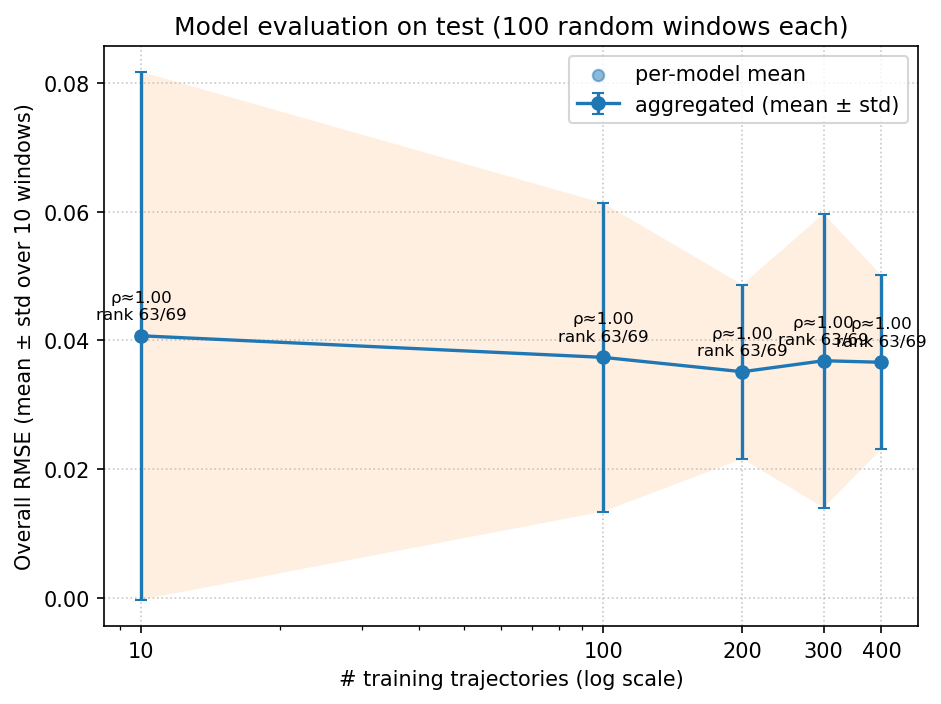

In [28]:
# === Plot overall RMSE (mean ± std over 10 windows) vs N_traj
#     with per-model points, aggregated error bars, and ρ(A)/ctrb annotations ===
if not df_eval_overall.empty:
    import numpy as np
    import matplotlib.pyplot as plt

    # Sort & copy
    dfp = df_eval_overall.copy()
    sort_cols = ["N_traj"] + (["model_file"] if "model_file" in dfp.columns else [])
    dfp = dfp.sort_values(sort_cols)

    # Scatter all per-model means (if multiple models per N_traj exist)
    plt.figure()
    plt.scatter(
        dfp["N_traj"].values,
        dfp["overall_rmse_mean"].values,
        s=30, alpha=0.5, label="per-model mean"
    )

    # Aggregate across models with the same N_traj
    grp = (dfp.groupby("N_traj", as_index=False)
              .agg(mean_overall=("overall_rmse_mean", "mean"),
                   err_win=("overall_rmse_std", "mean"),
                   n_models=("overall_rmse_mean", "count")))

    # Plot aggregated mean ± (mean window std)
    x = grp["N_traj"].values.astype(float)
    y = grp["mean_overall"].values.astype(float)
    e = grp["err_win"].values.astype(float)

    order = np.argsort(x)
    x, y, e = x[order], y[order], e[order]

    plt.errorbar(x, y, yerr=e, fmt='o-', capsize=3, lw=1.6, label="aggregated (mean ± std)")
    # Light band for ±1σ (window variability)
    y_lo, y_hi = y - e, y + e
    plt.fill_between(x, y_lo, y_hi, alpha=0.12)

    # Annotate with spectral radius and controllability rank if present
    has_rho = "rho(A)" in dfp.columns
    has_ctrb = "ctrb_rank" in dfp.columns and "nphi" in dfp.columns
    if has_rho or has_ctrb:
        for xi, yi in zip(x, y):
            sub = dfp[dfp["N_traj"] == xi]
            txts = []
            if has_rho and np.isfinite(sub["rho(A)"]).any():
                txts.append(f"ρ≈{sub['rho(A)'].mean():.2f}")
            if has_ctrb and (sub["ctrb_rank"].notna().any() and sub["nphi"].notna().any()):
                # show max rank/nphi for readability
                rank = int(sub["ctrb_rank"].max())
                nphi = int(sub["nphi"].max())
                txts.append(f"rank {rank}/{nphi}")
            if txts:
                plt.annotate("\n".join(txts),
                             (xi, yi), textcoords="offset points",
                             xytext=(0, 8), ha="center", fontsize=8)

    plt.xscale("log")
    plt.xticks(x, [str(int(v)) for v in x])
    plt.xlabel("# training trajectories (log scale)")
    plt.ylabel("Overall RMSE (mean ± std over 10 windows)")
    subtitle = f"Model evaluation on test ({int(globals().get('N_WINDOWS', 10))} random windows each)"
    plt.title(subtitle)
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[skip] nothing to plot.")
